# Advanced Machine Learning
---
Wojciech Kutak

# Project 2: Parsimonious Household Electricity Usage Prediction
This notebook explores advanced feature selection and model optimization techniques for predicting household electricity usage. Using a dataset with 500 features and a binary target, we apply correlation analysis, recursive feature elimination, and cross-validated hyperparameter tuning for several machine learning models (Logistic Regression, Random Forest, XGBoost). The workflow emphasizes parsimony, identifying the smallest subset of features that yields high predictive performance, by comparing feature rankings and model metrics across different strategies. Visualizations and summary statistics are provided to interpret model performance and feature importance.

--- 
## 1. Environment Setup and Data Loading

This section imports necessary libraries for data manipulation, visualization, machine learning models, and feature selection. It also defines global parameters like the data path and random state for reproducibility. The raw training and testing datasets are loaded and prepared for initial exploration.

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.base import BaseEstimator
from itertools import product
from tqdm import tqdm

from src.utils import load_data, cost_function

# Define the path to the data directory
DATA_PATH = os.path.join(os.curdir, 'data')
# Set a random state for reproducibility
random_state = 42
np.random.seed(random_state)

### Loading dataset

In [ ]:
# Load the training and testing datasets
X_train, y_train, X_test = load_data(DATA_PATH)
# Concatenate the training features and target for correlation analysis
ds_train = pd.concat([y_train.rename(columns={0:"target"}), X_train], axis=1)

--- 
## 2. Exploratory Data Analysis and Feature Pre-selection

This section focuses on understanding the relationships between features and the target variable. A **correlation matrix** for the entire feature set is visualized to identify potential multicollinearity. Subsequently, **Pearson and Spearman correlation coefficients** between individual features and the target are computed and plotted. Features exhibiting an absolute Pearson correlation of 0.1 or higher are pre-selected for further analysis, aiming to reduce dimensionality while retaining relevant information.

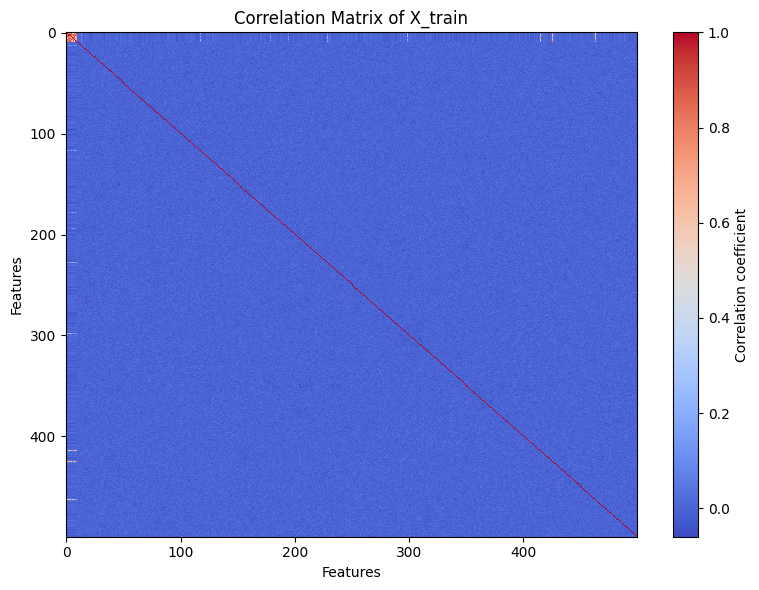

In [ ]:
plt.figure(figsize=(8, 6))
# Compute the Pearson correlation matrix for the training features
corr_matrix = X_train.corr()
# Display the correlation matrix as an image
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation Matrix of X_train')
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [ ]:
corr_matrices = []

# Iterate through different correlation methods (Pearson and Spearman)
for i, method in enumerate(['pearson', 'spearman']):
    # Compute the correlation matrix for the combined dataset (features + target)
    corr_matrix = ds_train.corr(method=method)
    # Extract the correlation of features with the target variable, sort by absolute value in descending order
    corr_method = corr_matrix["target"].sort_values(ascending=False)
    # Drop the 'target' row and reset the index to prepare for plotting
    corr_method = corr_method.drop(index='target', axis=0).abs().reset_index()
    corr_matrices.append(corr_method)

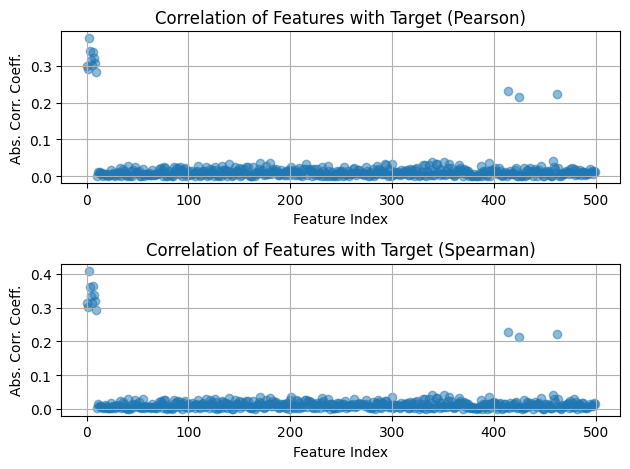

In [ ]:
# Plot the absolute correlation coefficients for each feature with the target
plt.figure(figsize=(10, 8))
for i, method in enumerate(['pearson', 'spearman']):
    plt.subplot(len(corr_matrices), 1, i + 1)
    plt.scatter(corr_matrices[i]['index'], corr_matrices[i]['target'], alpha=0.5)
    plt.title(f'Correlation of Features with Target ({method.capitalize()})')
    plt.xlabel('Feature Index')
    plt.ylabel('Abs. Corr. Coeff.')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Select the Pearson correlation matrix for feature selection
corr_matrix = corr_matrices[0]
# Identify features with an absolute Pearson correlation coefficient >= 0.1 with the target
feature_indices = [int(x) for x in corr_matrix[corr_matrix['target'] >= 0.1]['index'].values]
n = len(feature_indices)
print(f"Top {n} features with highest correlation with target (Pearson):")
print(feature_indices)

Top 13 features with highest correlation with target (Pearson):
[2, 3, 6, 7, 4, 8, 5, 0, 1, 9, 414, 462, 425]


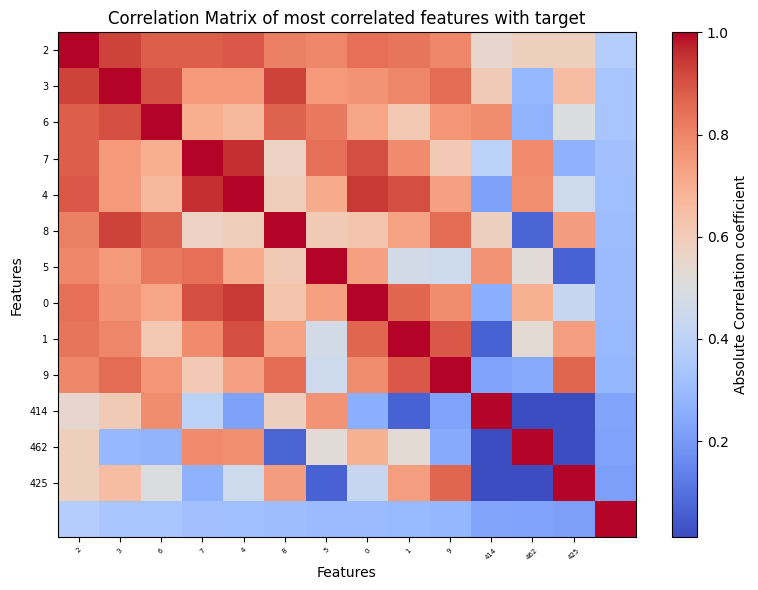

In [ ]:
plt.figure(figsize=(8, 6))
# Compute the absolute correlation matrix for all features
corr_matrix = ds_train.corr().abs()
# Create a list of the selected feature indices plus the 'target' for plotting
feature_indices_and_target = feature_indices + ['target']
# Display the correlation matrix for the selected features and the target
plt.imshow(corr_matrix[feature_indices_and_target].loc[feature_indices_and_target], cmap='coolwarm',
           interpolation='nearest', aspect='auto')
plt.colorbar(label='Absolute Correlation coefficient')
plt.title('Correlation Matrix of most correlated features with target')
plt.xticks(range(len(feature_indices)), feature_indices, rotation=45, size=5)
plt.yticks(range(len(feature_indices)), feature_indices, size=7)
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

--- 
## 3. Model Hyperparameter Tuning and Feature Selection with RFECV

This section outlines the core methodology for **model optimization and feature selection**. A `preprocess_features` function is introduced for scaling selected features. The `finetune_params` function performs **grid search with cross-validation** to identify optimal hyperparameters for a given model based on a custom `cost_function`. The `finetune_model` function orchestrates a **multi-stage hyperparameter tuning process**, carrying over best parameters between stages for refined optimization. Finally, **Recursive Feature Elimination with Cross-Validation (RFECV)** is applied to each optimized model to determine the most impactful features based on the custom scoring metric.

In [ ]:
def preprocess_features(X: pd.DataFrame, y: pd.DataFrame, feature_indices: list[int]):
    """
    Preprocesses the input features by scaling them and converts the target to a NumPy array.

    :param X: Pandas DataFrame of features.
    :param y: Pandas DataFrame of the target variable.
    :param feature_indices: List of integer indices corresponding to the features to be selected.
    :return: A tuple containing the scaled feature matrix as a NumPy array and the target vector as a NumPy array.
    """
    # Scale the selected features using StandardScaler
    X_np = StandardScaler().fit_transform(X.to_numpy()[:, feature_indices])
    # Convert the target variable to a flattened integer NumPy array
    y_np = y.to_numpy().astype(np.int32).ravel()
    return X_np, y_np

In [ ]:
# Preprocess the training features and target using the selected feature indices
X_train_np, y_train_np = preprocess_features(X_train, y_train, feature_indices)

In [ ]:
def finetune_params(model, X: np.ndarray, y: np.ndarray, param_grid: dict):
    """
    Finetune parameters for the model using cross-validation and a custom cost function.

    This function iterates through all combinations of hyperparameters provided in `param_grid`,
    performs 5-fold cross-validation, and evaluates the model using a defined `cost_function`.
    The best set of parameters is selected based on the highest score from the `cost_function`.

    :param model: The machine learning model (estimator) to be finetuned. It must have a `set_params` method
                  and support `predict_proba` for cross-validation.
    :param np.ndarray X: Feature matrix for training, typically preprocessed and scaled.
    :param np.ndarray y: Target vector corresponding to the feature matrix.
    :param dict param_grid: A dictionary where keys are parameter names (strings) and values are lists
                            of parameter values to try. `itertools.product` is used to generate all combinations.
    :return best_score, best_params: A tuple containing the highest `cost_function` score achieved and
                                      a dictionary of the corresponding best hyperparameters.
    """
    best_score = 0
    best_params = None
    # Iterate through all combinations of parameters using tqdm for progress visualization
    for params in tqdm(list(product(*param_grid.values())), desc=f"{type(model).__name__} Finetuning parameters"):
        param_dict = dict(zip(param_grid.keys(), params))
        model.set_params(**param_dict)
        # Perform 5-fold cross-validation to get probability predictions
        scores = cross_val_predict(model, X, y, cv=5, method='predict_proba', n_jobs=-1)
        # Calculate the score using the custom cost function
        score = cost_function(y, scores[:, 1], X.shape[1])
        # Update best score and parameters if the current score is higher
        if score > best_score:
            best_score = score
            best_params = param_dict
    return best_score, best_params

In [ ]:
def finetune_model(model_class: BaseEstimator, param_grid_stages: list[dict]):
    """
    Performs multi-stage hyperparameter tuning for a given model class.

    This function iteratively tunes hyperparameters in stages. The best parameters found in an earlier
    stage are carried over to initialize the model for subsequent stages, allowing for a more
    refined search.

    :param model_class: The class of the machine learning model (e.g., LogisticRegression, RandomForestClassifier).
                        It must inherit from `sklearn.base.BaseEstimator`.
    :param param_grid_stages: A list of dictionaries, where each dictionary represents a stage of parameter tuning.
                              Each dictionary contains parameter names as keys and lists of values to try.
    :return overall_best_params, overall_best_score: A tuple containing the dictionary of the overall best
                                                     hyperparameters found across all stages and the corresponding
                                                     best score.
    """
    overall_best_score = 0
    overall_best_params = {}
    model_name = model_class.__name__

    for i, param_grid in enumerate(param_grid_stages):
        print(f"{model_name} Finetuning parameters for stage {i + 1}...")
        # Initialize the model for the current stage, inheriting best params from previous stages
        model = model_class(random_state=random_state)
        model.set_params(**overall_best_params)
        # Finetune parameters for the current stage
        best_score, best_params = finetune_params(model, X_train_np, y_train_np, param_grid)
        print(f"{model_name} Best parameters for stage {i + 1} with score {best_score}: {best_params}")
        # Update the model with the best parameters found in the current stage
        model.set_params(**best_params)
        # Accumulate the best parameters across all stages
        overall_best_params.update(best_params)
        # Update the overall best score
        overall_best_score = max(best_score, overall_best_score)

    return overall_best_params, overall_best_score

In [ ]:
# Configuration for hyperparameter tuning of different models
configs = [
    {
        "model_class": LogisticRegression,
        "param_grid_stages": [
            # Stage 1: Regularization Type & Strength
            {
                'penalty': ['elasticnet', None], # Type of regularization to apply
                'C': [0.01, 0.1, 1, 10, 100], # Inverse of regularization strength
                'solver': ['saga'], # Solver to use for optimization problem. 'saga' supports 'elasticnet'
                'l1_ratio': [0.0, 0.1, 0.5, 0.9, 1.0] # The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1.
                                                    # For l1_ratio = 0 the penalty is an L2 penalty.
                                                    # For l1_ratio = 1 it is an L1 penalty.
                                                    # For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
            },
            # Stage 2: Class Imbalance
            {
                'class_weight': [None, 'balanced'] # Weights associated with classes in the form {class_label: weight}.
                                                  # 'balanced' uses the values of y to automatically adjust weights
                                                  # inversely proportional to class frequencies.
            },
        ]
    },
    {
        "model_class": RandomForestClassifier,
        "param_grid_stages": [
            # Stage 1: Tree Depth & Number
            {
                'n_estimators': [100, 300, 500], # The number of trees in the forest.
                'max_depth': [None, 5, 10, 20], # The maximum depth of the tree. None means unlimited depth.
            },
            # Stage 2: Splitting & Feature Selection
            {
                'min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node.
                'min_samples_leaf': [1, 2, 4], # The minimum number of samples required to be at a leaf node.
                'max_features': [None, 'sqrt', 'log2'], # The number of features to consider when looking for the best split.
            },
            # Stage 3: Class Imbalance
            {
                'class_weight': [None, 'balanced', 'balanced_subsample'] # Weights for classes.
                # 'balanced_subsample' weights are based on the subsample used for each tree.
            }
        ]
    },
    {
        "model_class": xgb.XGBClassifier,
        "param_grid_stages": [
            # Stage 1: Tree structure
            {
                'max_depth': np.linspace(1, 10, 10, dtype=int).tolist(), # Maximum depth of a tree.
                'min_child_weight': [1, 2, 3, 4, 5]
            },
            # Stage 2: Regularization
            {
                'gamma': [0, 0.1, 0.3], # Minimum loss reduction required to make a further partition on a leaf node.
                'alpha': [0.0] + np.logspace(-2, 3, 6).tolist(), # L1 regularization term on weights.
                'lambda': np.linspace(0, 50, 10).tolist()
            },
            # Stage 3: Subsampling
            {
                'subsample': [0.6, 0.8, 1.0], # Subsample ratio of the training instance.
                'colsample_bytree': [0.4, 0.6, 0.8, 1.0]
            },
            # Stage 4: Learning rate
            {
                'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
            }
        ]
    },
]

In [ ]:
def scoring(model: BaseEstimator, X: np.ndarray, y: np.ndarray) -> float:
    """
    Calculates a custom score for the model based on predicted probabilities.

    This function is intended to be used as a scoring callable for `RFECV`.
    It computes prediction probabilities and then applies a custom cost function
    to evaluate performance.

    :param model: The trained machine learning model (estimator) with a `predict_proba` method.
    :param X: Feature matrix on which to make predictions.
    :param y: True target values.
    :return: The score calculated by the `cost_function`.
    """
    # Get predicted probabilities for the positive class
    y_proba = model.predict_proba(X)
    # Calculate and return the custom cost function score
    return cost_function(y, y_proba[:, 1], X.shape[1])

In [ ]:
# Dictionaries to store the best hyperparameters and RFE results for each model
results = {}
rfes = {}

# Iterate through each model configuration defined in 'configs'
for config in configs:
    model_class, param_grid_stages = config["model_class"], config["param_grid_stages"]
    # Finetune the model's hyperparameters using the defined stages
    best_params, best_score = finetune_model(model_class, param_grid_stages)
    model_name = model_class.__name__
    # Store the best parameters and score
    results[model_name] = (best_params, best_score)

    # Initialize and fit Recursive Feature Elimination with Cross-Validation (RFECV)
    # The estimator is the model with its best finetuned parameters.
    # The scoring metric is our custom 'scoring' function.
    rfe = RFECV(
        estimator=model_class(random_state=random_state, **best_params),
        cv=5, # 5-fold cross-validation
        scoring=scoring, # Use the custom scoring function
        n_jobs=1, # Number of jobs to run in parallel. Set to 1 to avoid issues with some models/scoring.
    ).fit(X_train_np, y_train_np)
    # Print the features selected by RFE (ranked as 1)
    print(f"{model_name} best features:", rfe.get_feature_names_out(feature_indices))
    # Store the RFE object for later analysis
    rfes[model_name] = rfe

XGBClassifier Finetuning parameters for stage 1...


XGBClassifier Finetuning parameters: 100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


XGBClassifier Best parameters for stage 1 with score 4920: {'max_depth': 3, 'min_child_weight': 2}
XGBClassifier Finetuning parameters for stage 2...


XGBClassifier Finetuning parameters: 100%|██████████| 210/210 [00:21<00:00,  9.94it/s]


XGBClassifier Best parameters for stage 2 with score 4960: {'gamma': 0.3, 'alpha': 10.0, 'lambda': 22.22222222222222}
XGBClassifier Finetuning parameters for stage 3...


XGBClassifier Finetuning parameters: 100%|██████████| 12/12 [00:01<00:00,  8.77it/s]


XGBClassifier Best parameters for stage 3 with score 4960: {'subsample': 1.0, 'colsample_bytree': 1.0}
XGBClassifier Finetuning parameters for stage 4...


XGBClassifier Finetuning parameters: 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]


XGBClassifier Best parameters for stage 4 with score 4960: {'learning_rate': 0.3}
XGBClassifier best features: [2]


--- 
## 4. Performance Evaluation with Ranked Features

This section evaluates the performance of each optimized model as the number of features increases, following the feature ranking determined by RFECV. For each model, predictions are generated via **cross-validation** using incrementally larger subsets of the top-ranked features. The **custom cost function** is used to quantify performance, and the results are then plotted to visualize the relationship between model score and the number of features. This allows for identification of the most parsimonious feature sets that achieve optimal performance for each model.

In [ ]:
# Dictionary mapping model names to their respective classes
models = {
    "LogisticRegression": LogisticRegression,
    "RandomForestClassifier": RandomForestClassifier,
    "XGBClassifier": xgb.XGBClassifier,
}
# Dictionary to store scores for each model based on increasing number of features
scores = {name: [] for name in models.keys()}

# Iterate through each model and its RFE results
for model_name, rfe in rfes.items():
    # Retrieve the best parameters for the current model
    best_params = results[model_name][0]

    # Adjust feature rankings to be 0-indexed (RFE ranks from 1)
    features_ranking = [rank - 1 for rank in rfe.ranking_]
    # Create a mapping from RFE rank to original feature index
    features_ranking_names = [None]*X_train_np.shape[1]
    for i, rank in enumerate(features_ranking):
        features_ranking_names[rank] = feature_indices[i]
    print(f"{model_name} Features ranked:", features_ranking_names)

    # Evaluate model performance by incrementally adding features based on RFE ranking
    for i in range(len(features_ranking)):
        # Select features up to the current rank (inclusive)
        features = features_ranking[:i+1]
        # Perform 5-fold cross-validation to get probability predictions
        y_proba = cross_val_predict(models[model_name](**best_params),
                                    X_train_np[:, features], y_train_np,
                                    cv=5, method='predict_proba', n_jobs=-1)
        # Calculate the custom score based on the predictions and the number of features used
        score = cost_function(y_train_np, y_proba[:, 1], i+1)
        scores[model_name].append(score)

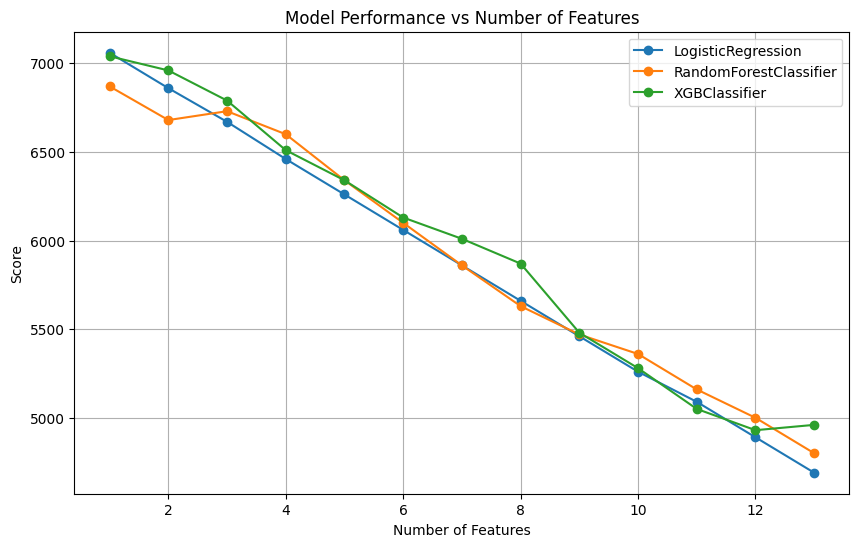

In [ ]:
plt.figure(figsize=(10, 6))
for model_name, score in scores.items():
    plt.plot(range(1, len(score) + 1), score, label=model_name, marker='o')
plt.title('Model Performance vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

In [ ]:
for model_name, rfe in rfes.items():
    print(f"For {model_name}:")
    # Retrieve the best parameters for the current model
    best_params = results[model_name][0]
    print("\tBest params:", best_params)
    # Get the names of the selected features (rank 1 features from RFE)
    print("\tBest feature set:", rfe.get_feature_names_out(feature_indices))

    # Adjust feature rankings to be 0-indexed
    features_ranking = [rank - 1 for rank in rfe.ranking_]
    # Map ranked indices back to original feature names
    features_ranking_names = [None]*X_train_np.shape[1]
    for i, rank in enumerate(features_ranking):
        features_ranking_names[rank] = feature_indices[i]
    print("\tFeatres ranking:", features_ranking_names)
    # Print the maximum score achieved for this model during the feature selection process
    print("\tBest score:", max(scores[model_name]))

For LogisticRegression:
	Best params: {'penalty': 'elasticnet', 'C': 0.01, 'solver': 'saga', 'l1_ratio': 1.0, 'class_weight': None}
	Best feature set: [2]
	Featres ranking: [2, 6, 414, 425, 462, 7, 9, 1, 0, 5, 8, 4, 3]
	Best score: 7060
For RandomForestClassifier:
	Best params: {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': None}
	Best feature set: [2]
	Featres ranking: [2, 3, 6, 4, 7, 8, 462, 425, 0, 414, 5, 1, 9]
	Best score: 6870
For XGBClassifier:
	Best params: {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.3, 'alpha': 10.0, 'lambda': 22.22222222222222, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.3}
	Best feature set: [2]
	Featres ranking: [2, 414, 462, 6, 425, 7, 4, 8, 0, 3, 9, 5, 1]
	Best score: 7040


--- 
## 5. Comprehensive Model Evaluation with Pre-defined Setups

This section conducts a **comprehensive evaluation of the models** using the pre-determined best hyperparameters and feature subsets. For each model, standard classification metrics (precision, recall, accuracy) are calculated alongside the custom `correct_detections` and `final_score` at different feature set sizes. The results are presented in a **DataFrame** for easy comparison and then visualized through several plots, showcasing how each metric changes with the inclusion of more features. This provides a detailed view of model performance and the impact of feature parsimony on various evaluation criteria.

In [ ]:
# Preprocess the training data using ALL 500 features (Strategy 5 context)
X_train_np, y_train_np = preprocess_features(X_train, y_train, [i for i in range(500)])

# Define the models to be used, mapping names to their respective classes
models = {
    "LogisticRegression": LogisticRegression,
    "RandomForestClassifier": RandomForestClassifier,
    "XGBClassifier": xgb.XGBClassifier,
}

# Pre-defined best setups for each model, including their best hyperparameters and feature rankings
models_setups = {
    "LogisticRegression": {
        "best_params": {'penalty': 'elasticnet', 'C': 0.01, 'solver': 'saga', 'l1_ratio': 1.0,
                           'class_weight': None},
        "features": [2, 6, 414, 425, 462, 7, 9, 1, 0, 5, 8, 4, 3]},
    "RandomForestClassifier": {
        "best_params": {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2,
                               'min_samples_leaf': 4, 'max_features': 'sqrt', 'class_weight': None},
        "features": [2, 3, 6, 4, 7, 8, 462, 425, 0, 414, 5, 1, 9]},
    "XGBClassifier": {
        "best_params": {'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.3, 'alpha': 10.0,
                      'lambda': 22.22222222222222, 'subsample': 1.0, 'colsample_bytree': 1.0,
                      'learning_rate': 0.3},
        "features": [2, 414, 462, 6, 425, 7, 4, 8, 0, 3, 9, 5, 1]},
}

# Dictionary to store various performance metrics for each model and feature subset
metrics = {
    "model_name": [],
    "feature_subset": [],
    "precision": [],
    "recall": [],
    "accuracy": [],
    "correct_detections": [], # Custom metric related to the cost function
    "final_score": [], # The main custom cost function score
}
models_names_metrics = [] # List to store combined model name and feature count for DataFrame index

# Iterate through each model setup
for i, model_name in enumerate(models_setups.keys()):
    model_setup = models_setups[model_name]
    best_params = model_setup["best_params"]
    features = model_setup["features"]
    model = models[model_name](random_state=random_state, **best_params)

    # Iterate through increasing subsets of features for each model
    for j in range(len(features)):
        feature_subset = features[:j+1]
        # Perform 5-fold cross-validation to get predicted probabilities
        y_proba = cross_val_predict(model,
                                    X_train_np[:, feature_subset],
                                    y_train_np, cv=5, method='predict_proba',
                                    n_jobs=-1)
        # Convert probabilities to binary predictions (threshold at 0.5)
        y_pred = np.where(y_proba[:, 1] > 0.5, 1, 0)

        # Calculate standard classification metrics
        cm = confusion_matrix(y_train_np, y_pred)
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_train_np, y_pred, average='binary')
        accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)

        # Calculate custom scores
        score = cost_function(y_train_np, y_proba[:, 1], len(feature_subset))
        correct_detections = (score + 200*len(feature_subset)) // 10 # Derived from cost function properties

        # Store metrics
        metrics["precision"].append(round(precision, 3))
        metrics["recall"].append(round(recall, 3))
        metrics["accuracy"].append(round(accuracy, 3))
        metrics["correct_detections"].append(correct_detections)
        metrics["final_score"].append(round(score, 3))
        metrics["feature_subset"].append(feature_subset)
        metrics["model_name"].append(model_name)
        models_names_metrics.append(f"{model_name}_{j+1}")

# Create a Pandas DataFrame from the collected metrics
metrics_df = pd.DataFrame(metrics, index=models_names_metrics)
metrics_df

,model_name,feature_subset,precision,recall,accuracy,correct_detections,final_score
LogisticRegression_1,LogisticRegression,[2],0.720,0.654,0.707,726,7060
LogisticRegression_2,LogisticRegression,"[2, 6]",0.718,0.656,0.706,729,6890
LogisticRegression_3,LogisticRegression,"[2, 6, 414]",0.718,0.656,0.706,729,6690
LogisticRegression_4,LogisticRegression,"[2, 6, 414, 425]",0.718,0.656,0.706,729,6490
LogisticRegression_5,LogisticRegression,"[2, 6, 414, 425, 462]",0.718,0.656,0.706,729,6290
LogisticRegression_6,LogisticRegression,"[2, 6, 414, 425, 462, 7]",0.718,0.656,0.706,729,6090
LogisticRegression_7,LogisticRegression,"[2, 6, 414, 425, 462, 7, 9]",0.718,0.656,0.706,729,5890
LogisticRegression_8,LogisticRegression,"[2, 6, 414, 425, 462, 7, 9, 1]",0.718,0.656,0.706,729,5690
LogisticRegression_9,LogisticRegression,"[2, 6, 414, 425, 462, 7, 9, 1, 0]",0.718,0.656,0.706,729,5490
LogisticRegression_10,LogisticRegression,"[2, 6, 414, 425, 462, 7, 9, 1, 0, 5]",0.718,0.656,0.706,729,5290


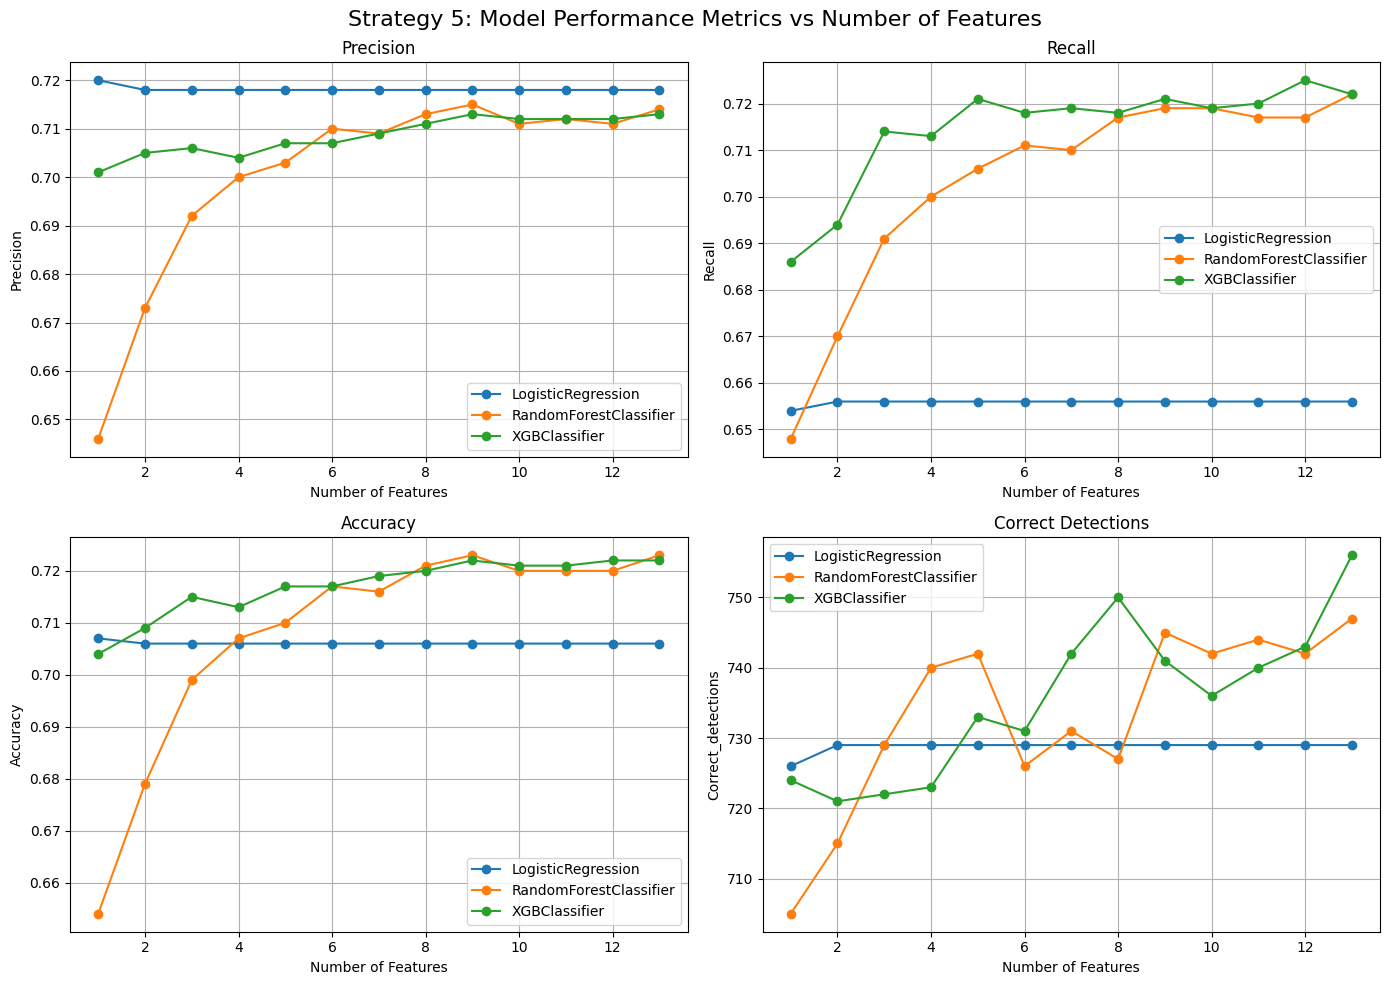

In [ ]:
# Create a 2x2 subplot grid for performance metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Define the metrics to be plotted and their corresponding titles
metrics_to_plot = ['precision', 'recall', 'accuracy', 'correct_detections']
titles = ['Precision', 'Recall', 'Accuracy', 'Correct Detections']

# Iterate through each subplot, metric, and title
for ax, metric, title in zip(axes.flat, metrics_to_plot, titles):
    # Plot performance for each model
    for model in metrics_df['model_name'].unique():
        df = metrics_df[metrics_df['model_name'] == model]
        num_features = df['feature_subset'].apply(len)
        ax.plot(num_features, df[metric], marker='o', label=model)
    ax.set_title(title)
    ax.set_xlabel('Number of Features')
    ax.set_ylabel(metric.capitalize())
    ax.grid(True)
    ax.legend()

plt.suptitle('Strategy 5: Model Performance Metrics vs Number of Features', fontsize=16)
plt.tight_layout()
plt.show()

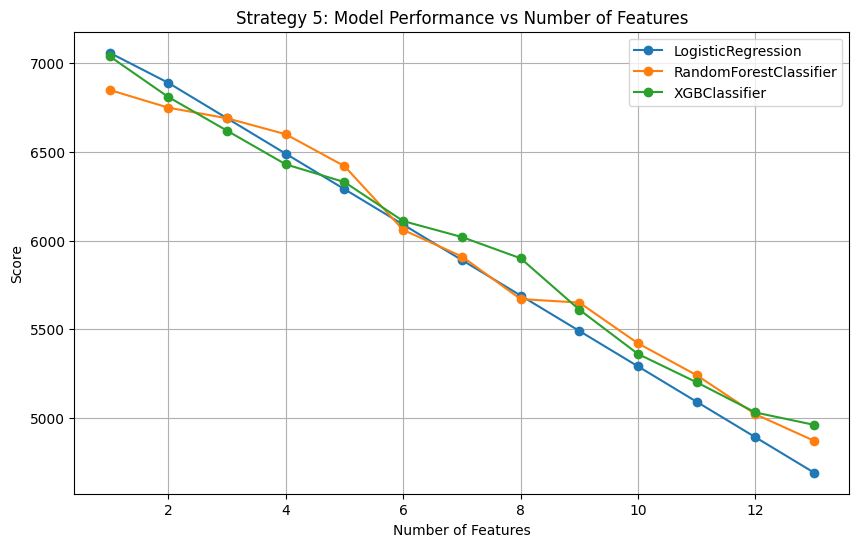

In [ ]:
plt.figure(figsize=(10, 6))
for model_name in metrics_df['model_name'].unique():
    df = metrics_df[metrics_df['model_name'] == model_name]
    num_features = df['feature_subset'].apply(len)
    plt.plot(num_features, df["final_score"], label=model_name, marker='o')
plt.title('Strategy 5: Model Performance vs Number of Features (Custom Score)')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

--- 
## 6. Aggregated Feature Importance Analysis

This final section aggregates the feature rankings from all evaluated models to derive a **consensus feature importance score**. By combining the individual rankings, a more robust understanding of which features are consistently important across different model architectures is achieved. A bar plot visualizes these **mean ranking scores**, highlighting the most universally significant features for the prediction task. This provides valuable insights for further feature engineering or simpler model deployment.

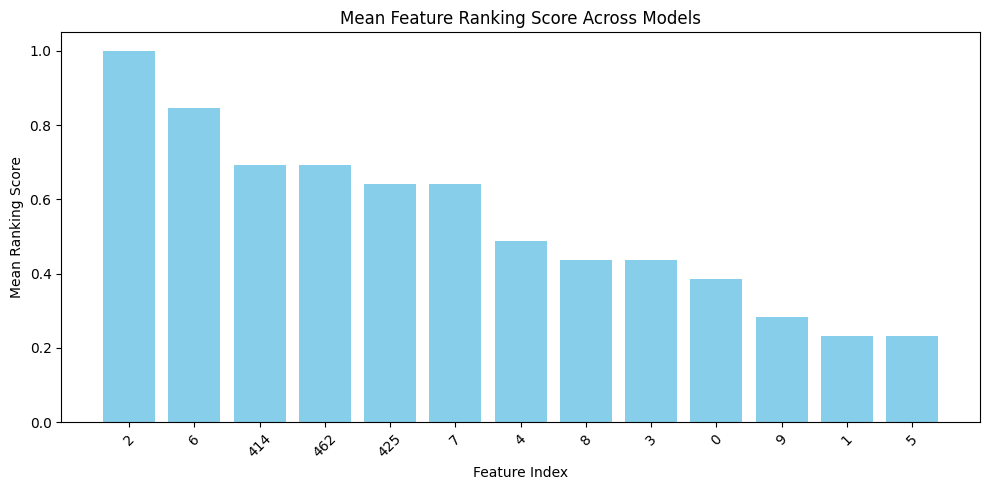

In [ ]:
# Extract the feature rankings from each model's setup
feature_rankings = [model_setup["features"] for model_setup in models_setups.values()]

# Initialize a dictionary to store the sum of ranking scores for each feature
mean_feature_ranking_score = {}
# Get the number of models/rankings and the total number of features considered in each ranking
num_rankings = len(feature_rankings)
num_features = len(feature_rankings[0])

# Calculate a score for each feature based on its position in each model's ranking.
# A higher score is given to features that appear earlier (are more important) in a ranking.
for ranking in feature_rankings:
    for i, feature in enumerate(ranking):
        # The score is (total_features - current_rank). Higher rank means higher score.
        mean_feature_ranking_score[feature] = mean_feature_ranking_score.get(feature, 0) + (num_features - i)

# Normalize the summed ranking scores by the maximum possible total score to get a mean score
mean_feature_ranking_score = {k: v / (num_rankings * num_features) for k, v in mean_feature_ranking_score.items()}

# Sort features by their mean ranking score in descending order
sorted_mean_feature_ranking = sorted(mean_feature_ranking_score.items(), key=lambda x: x[1], reverse=True)

# Prepare data for plotting
features, scores = zip(*sorted_mean_feature_ranking)

# Generate a bar plot of the mean feature ranking scores
plt.figure(figsize=(10, 5))
plt.bar([str(f) for f in features], scores, color='skyblue')
plt.xlabel('Feature Index')
plt.ylabel('Mean Ranking Score')
plt.title('Mean Feature Ranking Score Across Models')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Display the sorted list of features and their mean ranking scores.
# This provides a consolidated view of feature importance across different models.
sorted_mean_feature_ranking

[(2, 0.9230769230769231),
 (6, 0.7692307692307693),
 (414, 0.6153846153846154),
 (462, 0.6153846153846154),
 (425, 0.5641025641025641),
 (7, 0.5641025641025641),
 (4, 0.41025641025641024),
 (8, 0.358974358974359),
 (3, 0.358974358974359),
 (0, 0.3076923076923077),
 (9, 0.20512820512820512),
 (1, 0.15384615384615385),
 (5, 0.15384615384615385)]